In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(24)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/mai2021/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36485 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:40648 Dashboard: http://127.0.0.1:36485/status,Cluster Workers: 8 Cores: 56 Memory: 251.63 GiB


In [2]:
import numpy as np
import xarray as xr
import qgutils
from xgcm.grid import Grid
import os.path as op
import gcm_filters
# import dask_image.ndfilters as ndfilters
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/tuchida/msqg/seas-forcing/'
rund = '/store/tuchida/msom/msqg/'

In [4]:
U     = .1
T     = 5e5    # seconds
tau0  = .0001
dt    = 5e-2
Rd    = 5e4   # Rossby radius (50km)
Re4   = 4e3
# f0 = 8e-5
beta  = .5
N     = 1024   # Number of horizontal grids
L0    = 80
H     = 5e3
dx    = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny  = 360
Rom   = .025
Ekb   = .002*2
ntime = int(62.2*5)+1

percent = 20
nmemb = 100

ncoars = 4
DX = dx * ncoars

In [29]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd == 2:
        psi = np.pad(psi,((1,1),(1,1)),'constant')
    elif nd == 3:
        psi = qgutils.pad_bc(psi)
    elif nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi


def laplacian(psi, Delta=1, bc='dirichlet', padded=False, 
              dim=['Z','Yp1','Xp1'], chunks={'Yp1':100,'Xp1':100}
             ):
    
    nd = psi.ndim
    if padded:
        psi_padded = psi
    else:
        if nd == 3:
            psi_padded = xr.DataArray(qgutils.pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)
        else:
            psi_padded = xr.DataArray(pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)

    lap = (psi_padded.isel(Yp1=slice(2,None),Xp1=slice(1,-1)).data 
           + psi_padded.isel(Yp1=slice(None,-2),Xp1=slice(1,-1)).data
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(2,None)).data 
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(None,-2)).data
           - 4*psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data
          ) / Delta**2

    return xr.DataArray(lap, dims=psi_padded.dims, 
                        coords=psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).coords
                       )

In [21]:
kZ = 1
dsb = xr.open_zarr(op.join(rund,"MeanPTR001/%03d-%03d" 
                   % (0,6)))
    
P0b = dsb.ptr0b.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    
P0 = pad_bc(P0b)
    
P0x = np.diff(P0[...,1:-1,:], axis=-1) / DX
P0x = .5*(P0x[...,1:] + P0x[...,:-1])
P0y = np.diff(P0[...,1:-1], axis=-2) / DX
P0y = .5*(P0y[...,1:,:] + P0y[...,:-1,:])

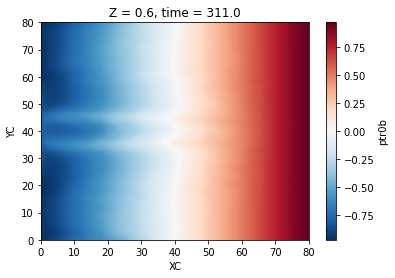

In [33]:
P0b.isel(time=0,Z=kZ).plot()

In [7]:
for i in range(nmemb+1):
    if i < nmemb:
        if i == 0:
            q = xr.open_zarr(op.join(rund, 'run%03d/vars001' % i)
                            ).q.isel(time=slice(0,7))
        else:
            q = xr.concat([q,xr.open_zarr(op.join(rund, 'run%03d/vars001' % i)
                                         ).q.isel(time=slice(0,7))
                          ], 'nmemb')
    else:
        q = xr.concat([q,xr.open_zarr(op.join(rund, 'ctrl/vars001')
                                     ).q.isel(time=slice(0,7))
                      ], 'nmemb')
            
qb = pad_bc(q.mean('nmemb').coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean())

qbx = np.diff(qb[...,1:-1,:], axis=-1) / DX
qbx = .5*(qbx[...,1:] + qbx[...,:-1])
qby = np.diff(qb[...,1:-1], axis=-2) / DX
qby = .5*(qby[...,1:,:] + qby[...,:-1,:])

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 47% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 47% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


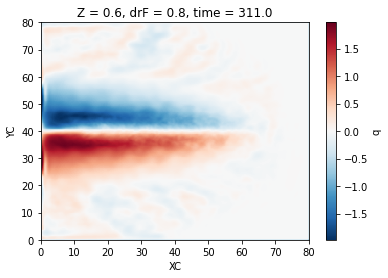

In [34]:
q.isel(time=0,Z=kZ).mean('nmemb').coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean().plot()

In [23]:
# dsk = xr.open_zarr(op.join(rund,"Kappas001/Z%1d/n04_%03d-%03d" % (kZ,0,6)))
dskopt = xr.open_zarr(op.join(rund,"Kappas001/Z%1d/n04_%03d-%03d_opt" % (kZ,0,6)))
dsp = xr.open_zarr(op.join(rund,"EddyFlux001/%03d-%03d" % (0,6)))
dsp

<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * time     (time) float32 311.0 312.0 313.0 314.0 315.0 316.0 317.0
Data variables:
    upPp0    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    upPp1    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    upPp2    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    upPp3    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    upqp     (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    vpPp0    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    vpPp1    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    vpPp2    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    vpPp3    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    vpqp     (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>

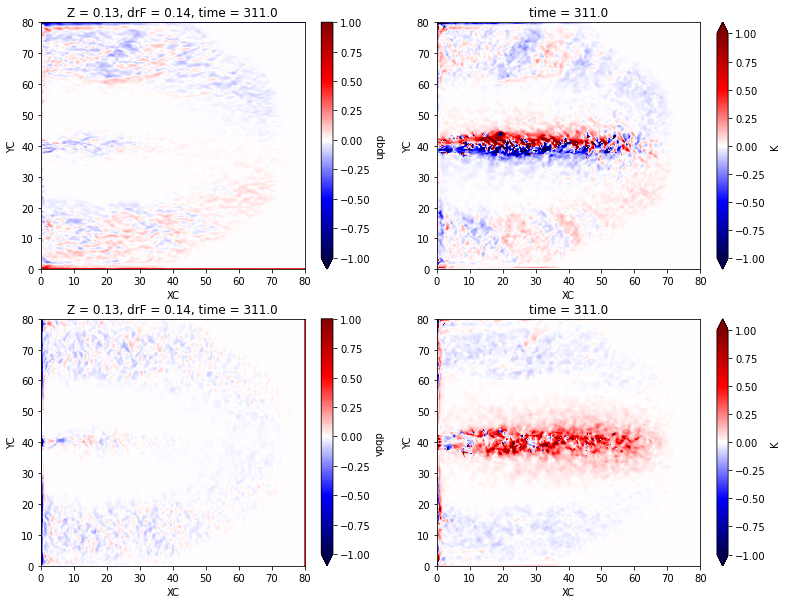

In [25]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
dsp.upqp.isel(time=0,Z=kZ).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean().plot(ax=axes[0,0], cmap='seismic', vmax=1)
# (-dsk.K[...,0,0]*qbx - dsk.K[...,1,0]*qby).isel(time=0).plot(ax=ax2, cmap='seismic', vmax=30)
(-dskopt.K[...,0,0]*qbx[:,kZ] - dskopt.K[...,1,0]*qby[:,kZ]).isel(time=0).plot(ax=axes[0,1], cmap='seismic', vmax=1)
dsp.vpqp.isel(time=0,Z=kZ).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean().plot(ax=axes[1,0], cmap='seismic', vmax=1)
# (-dsk.K[...,0,0]*qbx - dsk.K[...,1,0]*qby).isel(time=0).plot(ax=ax2, cmap='seismic', vmax=30)
(-dskopt.K[...,0,1]*qbx[:,kZ] - dskopt.K[...,1,1]*qby[:,kZ]).isel(time=0).plot(ax=axes[1,1], cmap='seismic', vmax=1)

## Could the difference be due to the rotational component?

In [36]:
upqpb = dsp.upqp.isel(time=0).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
vpqpb = dsp.vpqp.isel(time=0).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    
upqp = qgutils.pad_bc(upqpb)[kZ]
vpqp = qgutils.pad_bc(vpqpb)[kZ]
    
upqpx = np.diff(upqp[...,1:-1,:], axis=-1) / DX
upqpx = .5*(upqpx[...,1:] + upqpx[...,:-1])
vpqpy = np.diff(vpqp[...,1:-1], axis=-2) / DX
vpqpy = .5*(vpqpy[...,1:,:] + vpqpy[...,:-1,:])
divFq = upqpx + vpqpy

In [38]:
GK0b = (-dskopt.K[...,0,0]*qbx[:,kZ] - dskopt.K[...,1,0]*qby[:,kZ]).isel(time=0)
GK1b = (-dskopt.K[...,0,1]*qbx[:,kZ] - dskopt.K[...,1,1]*qby[:,kZ]).isel(time=0)

GK0 = pad_bc(GK0b)
GK1 = pad_bc(GK1b)
    
GK0x = np.diff(GK0[...,1:-1,:], axis=-1) / DX
GK0x = .5*(GK0x[...,1:] + GK0x[...,:-1])
GK1y = np.diff(GK1[...,1:-1], axis=-2) / DX
GK1y = .5*(GK1y[...,1:,:] + GK1y[...,:-1,:])
divGKq = GK0x + GK1y

<ipython-input-42-0a90e94d8645>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(P0b.XC, P0b.YC, divFq, vmin=-.2, vmax=.2, cmap='seismic')
<ipython-input-42-0a90e94d8645>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(P0b.XC, P0b.YC, divGKq, vmin=-.2, vmax=.2, cmap='seismic')


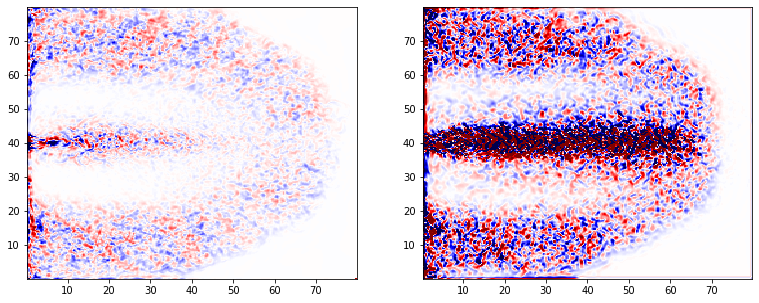

In [42]:
fig, (ax1,ax2) = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
ax1.pcolormesh(P0b.XC, P0b.YC, divFq, vmin=-.2, vmax=.2, cmap='seismic')
ax2.pcolormesh(P0b.XC, P0b.YC, divGKq, vmin=-.2, vmax=.2, cmap='seismic')

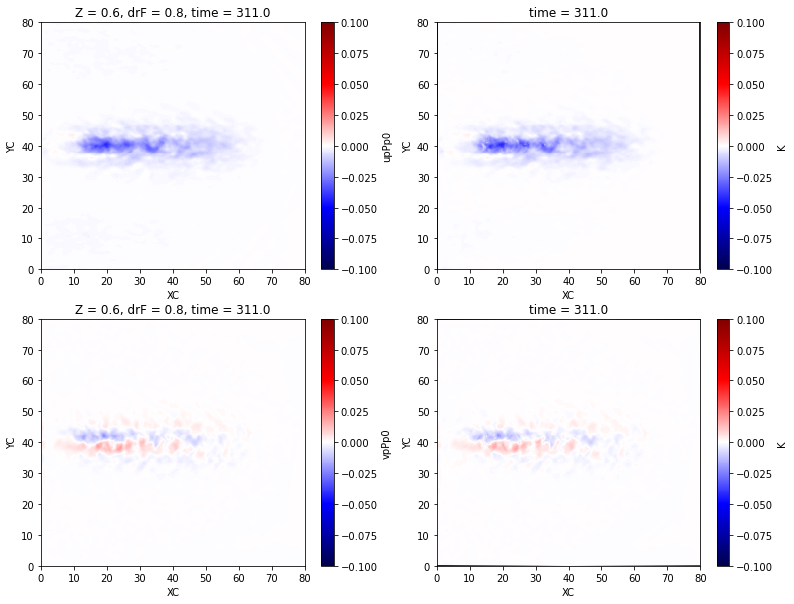

In [40]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
dsp.upPp0.isel(time=0).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean().plot(ax=axes[0,0], cmap='seismic', vmax=.1)
# (-dsk.K[...,0,0]*qbx - dsk.K[...,1,0]*qby).isel(time=0).plot(ax=ax2, cmap='seismic', vmax=30)
(-dskopt.K[...,0,0]*P0x[:,kZ] - dskopt.K[...,1,0]*P0y[:,kZ]).isel(time=0).plot(ax=axes[0,1], cmap='seismic', vmax=.1)
dsp.vpPp0.isel(time=0).coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean().plot(ax=axes[1,0], cmap='seismic', vmax=.1)
# (-dsk.K[...,0,0]*qbx - dsk.K[...,1,0]*qby).isel(time=0).plot(ax=ax2, cmap='seismic', vmax=30)
(-dskopt.K[...,0,1]*P0x[:,kZ] - dskopt.K[...,1,1]*P0y[:,kZ]).isel(time=0).plot(ax=axes[1,1], cmap='seismic', vmax=.1)

Text(0.5, 1.0, '$\\kappa^{vv}$')

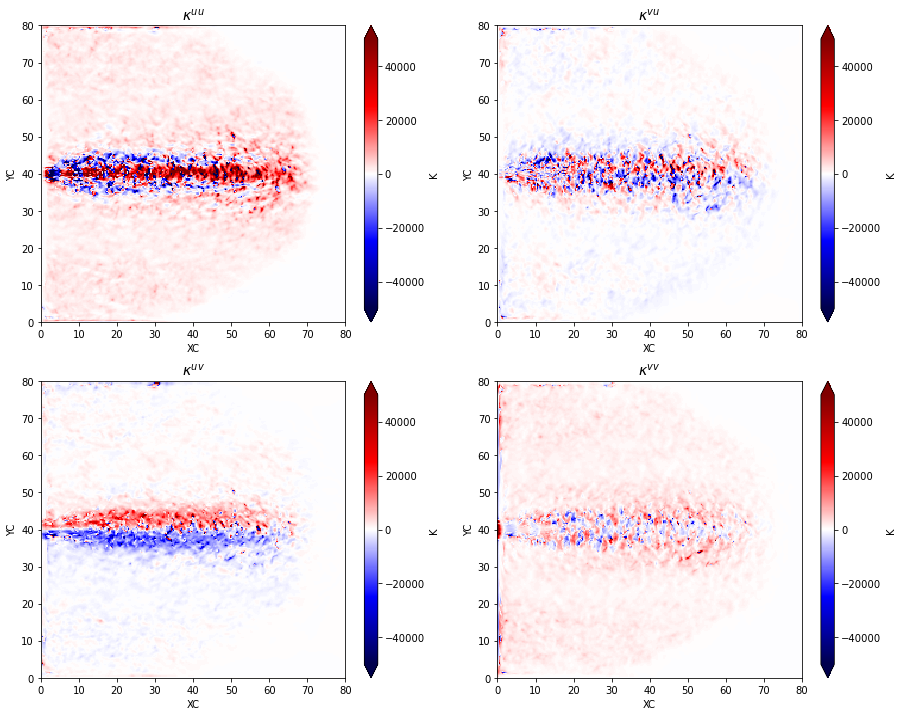

In [50]:
itime=0

fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2)
(dskopt.K[...,0,0].isel(time=itime)*U*Rd).plot(ax=axes[0,0],
                                      vmin=-5e4, vmax=5e4, cmap='seismic', rasterized=True)
(dskopt.K[...,0,1].isel(time=itime)*U*Rd).plot(ax=axes[0,1],
                                      vmin=-5e4, vmax=5e4, cmap='seismic', rasterized=True)
(dskopt.K[...,1,0].isel(time=itime)*U*Rd).plot(ax=axes[1,0],
                                      vmin=-5e4, vmax=5e4, cmap='seismic', rasterized=True)
(dskopt.K[...,1,1].isel(time=itime)*U*Rd).plot(ax=axes[1,1],
                                      vmin=-5e4, vmax=5e4, cmap='seismic', rasterized=True)
axes[0,0].set_title(r"$\kappa^{uu}$", fontsize=14)
axes[0,1].set_title(r"$\kappa^{vu}$", fontsize=14)
axes[1,0].set_title(r"$\kappa^{uv}$", fontsize=14)
axes[1,1].set_title(r"$\kappa^{vv}$", fontsize=14)
# axes[1,0].set_xlabel(r"X [km]", fontsize=13)
# axes[1,1].set_xlabel(r"X [km]", fontsize=13)
# axes[0,0].set_ylabel(r"Y [km]", fontsize=13)
# axes[1,0].set_ylabel(r"Y [km]", fontsize=13)
# fig.subplots_adjust(right=0.86, hspace=.26) 
# cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
# cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
# cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)